In [1]:
############################################################################
##
## Copyright (C) 2021 NVIDIA Corporation.  All rights reserved.
##
## NVIDIA Sample Code
##
## Please refer to the NVIDIA end user license agreement (EULA) associated
## with this source code for terms and conditions that govern your use of
## this software. Any use, reproduction, disclosure, or distribution of
## this software and related documentation outside the terms of the EULA
## is strictly prohibited.
##
############################################################################

# Modeling and Explainability

In [4]:
###### https://degravek.github.io/project-pages/project1/2016/11/12/New-Notebook/ #################
# with modifications and GPU acceleration by Mark J Bennett mbennett@nvidia.com and Emanuel Scoullos escoullos@nvidia.com

###### Best when compared to:
###### https://www.bankofengland.co.uk/-/media/boe/files/working-paper/2019/
######        machine-learning-explainability-in-finance-an-application-to-default-risk-analysis.pdf
%matplotlib inline
import time
total_start = time.time()
from collections import OrderedDict
import gc
import glob
import os
import pickle
import re
import sys

from typing import Union

import cudf
import cupy as cp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, roc_curve, auc,
                             precision_score, recall_score, precision_recall_curve, f1_score, 
                             accuracy_score)

from tqdm.autonotebook import tqdm
import xgboost as xgb

/tmp/ipykernel_1272610/937460551.py:33: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [8]:
##############
##############
use_cpu = False  # whether to use CPU or GPU

##############
##############

if use_cpu:
    print('using CPU')
    from pandas import read_parquet, concat, merge, DataFrame, get_dummies, Series, isnull
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from numpy import zeros, double, int8, int16, int64, concatenate, argmax, argmin
else:
    print('using GPU')
    from cudf import read_parquet, concat, merge, DataFrame, get_dummies, Series
    from cupy import zeros,double, int8, int16, int64, concatenate, argmax, argmin
    from cuml.model_selection import train_test_split
    from cuml.preprocessing import OneHotEncoder, StandardScaler
    from cuml.metrics import precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score
    
import shap

from clfmodel import binaryClassification

np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# make sure the path below points to the data directory where the FannieMae data was downloaded.
clean_data_path = '/rapids/notebooks/cleaned_data'
figures_path = '/rapids/notebooks/figures'
os.makedirs(figures_path, exist_ok=True)

using GPU


ModuleNotFoundError: No module named 'torch'

In [9]:
def cupy2numpy(obj, use_cpu):
    if use_cpu and isinstance(obj, cp._core.core.ndarray):
        return obj.get()
    elif use_cpu and isinstance(obj, cudf.core.series.Series):
        return obj.to_array()
    return obj

In [5]:
with open(f'{clean_data_path}/fnma_mappings.pkl', 'rb') as f:
    mappings = pickle.load(f)
print('\n'.join(mappings.keys()))

Channel
SellerName
FTHomeBuyer
LoanPurpose
PropertyType
OccStatus
PropertyState
Zip
ProductType
MortInsType


# Read cleaned FannieMae Dataset from notebook 1

In [6]:
df = read_parquet(f'{clean_data_path}/fnma_cleaned.pq')

In [7]:
type(df), df.shape

(cudf.core.dataframe.DataFrame, (11232359, 22))

In [8]:
Xcolumns=['Channel',
         'SellerName',
         'OrInterestRate',
         'OrUnpaidPrinc',
         'OrLoanTerm',
         'OrCLTV',
         'NumBorrow',
         'DTIRat',
         'CreditScore',
         'FTHomeBuyer',
         'LoanPurpose',
         'PropertyType',
         'NumUnits',
         'OccStatus',
         'PropertyState',
         'Zip',
         'ProductType',
         'CoCreditScore',
         'Extra',
         'MortInsType']
CONTINUOUS_COLUMNS = ['OrInterestRate', 'OrUnpaidPrinc', 'OrLoanTerm', 'OrCLTV', 'NumBorrow', 'DTIRat', 
                      'CreditScore', 'NumUnits', 'CoCreditScore', 'Extra']
CATEGORICAL_COLUMNS = sorted([i for i in Xcolumns if i not in CONTINUOUS_COLUMNS])
LABEL_COLUMNS = ['Default']

# Predicting Delinquent Loans

 Train test split and apply Random Oversampling to minority class (if desired)

In [9]:

from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN

y = df['Default']#.values
X = df.drop(['Default','LoanID'], axis=1)#.values
Xcolumns = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=11)
X_train = X_train[CATEGORICAL_COLUMNS + CONTINUOUS_COLUMNS]
X_test = X_test[CATEGORICAL_COLUMNS + CONTINUOUS_COLUMNS]


In [10]:
print(X_train.shape, y_train.shape)
print(y_train.sum(), y_test.sum())

(10109124, 20) (10109124,)
399797 32439


In [11]:
X_train.head()

,Channel,FTHomeBuyer,LoanPurpose,MortInsType,OccStatus,ProductType,PropertyState,PropertyType,SellerName,Zip,OrInterestRate,OrUnpaidPrinc,OrLoanTerm,OrCLTV,NumBorrow,DTIRat,CreditScore,NumUnits,CoCreditScore,Extra
1550205,2,0,2,0,1,0,4,4,31,902,5.99,93000,180,19.0,1.0,23.0,805.0,1,766.868035,1.077555
1137124,1,0,0,0,1,0,21,3,48,120,6.50,206000,360,58.0,1.0,64.0,649.0,1,766.868035,1.077555
541402,2,0,0,0,1,0,23,4,31,437,6.50,85000,360,25.0,2.0,35.0,788.0,1,799.000000,1.077555
5374781,2,0,2,0,0,0,28,3,3,195,5.25,59000,180,74.0,1.0,38.0,676.0,1,766.868035,1.077555
2269471,1,0,2,0,1,0,51,4,3,475,6.25,366000,360,79.0,1.0,48.0,770.0,1,766.868035,1.077555


In [12]:
data_prep_time = time.time()

In [13]:
def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', save_path=None, cmap=plt.cm.cool):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    if save_path and isinstance(save_path, str):
        plt.savefig(save_path, dpi=600)


## XGBoost

Alright, now we’re ready to make some predictions! We first randomly split the data into a training set and a test set using the Scikit-Learn train_test_split_function. From these two sets, we idenfiy the target (“Default”) vector, and feature arrays.

In [63]:
y_train.sum()/len(y_train)

0.039548134932364074

In [64]:
scaling = (len(y_train)-y_train.sum())/y_train.sum()
scaling = float(scaling)

print('scaling:', scaling )   

scaling: 24.285642463550253


In [65]:
# parameters here are not optimized. Feel free to experiment!
params = {
    'num_rounds':        100,
    'max_depth':         12,
    'max_leaves':        0,
    'alpha':             3,
    'lambda':            1,
    'eta':               0.17,
    'subsample':         1,
    'sampling_method':   'gradient_based',
    'scale_pos_weight':  scaling,
    'max_delta_step':    1,
    'max_bin':           2048,
    'tree_method':       'gpu_hist',
    'grow_policy':       'lossguide',
    'n_gpus':            1,
    'objective':         'binary:logistic',#'binary:hinge'
    'eval_metric':       'aucpr',#'error',#'auc', 'logloss'
    'predictor':         'gpu_predictor',
    'num_parallel_tree': 1,
    "min_child_weight":  2,
    'verbose':           True
}

if use_cpu:
    print('training XGBoost model on cpu')
    params['tree_method'] = 'hist'
    params['sampling_method'] = 'uniform'
    params['predictor'] = 'cpu_predictor'
    

In [66]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
    
evals = [(dtest, 'test'), (dtrain, 'train')]

In [67]:
start = time.time()

model = xgb.train(params, dtrain, params['num_rounds'], evals=evals,
                          early_stopping_rounds=10)
print(f'Elapsed time: {time.time() - start: 0.3f} s')

[22:27:03] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1623267594558/work/include/xgboost/generic_parameters.h:38: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.
[22:27:03] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1623267594558/work/src/learner.cc:573: 
Parameters: { "num_rounds", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	test-aucpr:0.16717	train-aucpr:0.18319
[1]	test-aucpr:0.18538	train-aucpr:0.20131
[2]	test-aucpr:0.20371	train-aucpr:0.22097
[3]	test-aucpr:0.22488	train-aucpr:0.24358
[4]	test-aucpr:0.24571	train-aucpr:0.26775
[5]	test-aucpr:0.26445	train-aucpr:0.28947
[6]	

In [ ]:
model.save_model(f'{clean_data_path}/xgb_model')

In [20]:
# make predictions on the test set using our trained model
cp.cuda.Device(0).use()
use_f1_measure = True

preds = model.predict(dtest)
if isinstance(preds, np.ndarray) and not use_cpu:
    preds = cp.array(preds)
    
true_labels = y_test.astype(int).values.squeeze()
true_labels = cupy2numpy(true_labels, use_cpu)
precision, recall, thresholds = precision_recall_curve(true_labels, preds)

if use_f1_measure:
    # apply the threshold using F1 measure to the prediction.
    threshold_idx = cupy2numpy(np.argmax((2 * precision * recall)/ (precision + recall+1e-7)), True)
    pred_labels = (preds >= thresholds[threshold_idx]).astype(int)
else:
    # apply the threshold TPR-FPR to the prediction.
    fpr, tpr, thresholds = roc_curve(cupy2numpy(true_labels, True), cupy2numpy(preds, True))
    threshold_idx = cupy2numpy(np.argmax(tpr - fpr), True)
    pred_labels = (preds >= thresholds[threshold_idx]).astype(int)
    print(f'TPR: {tpr[threshold_idx]: 0.4f}')
    print(f'FPR: {fpr[threshold_idx]: 0.4f}')
    
    
print(f'Threshold: {thresholds[threshold_idx]: 0.4f}')
print(f'Precision: {precision[threshold_idx]: 0.4f}')
print(f'Recall: {recall[threshold_idx]: 0.4f}')
print('Predicted', pred_labels.sum())
print('Actual', true_labels.sum())
# compute the auc, this should match the last test auc output above
#
auc_measure = roc_auc_score(true_labels, preds)

print(f'AUC {auc_measure: 0.4f}')

print (f'Accuracy: {accuracy_score(true_labels, pred_labels): 0.4f}')

print (f'F1: {(2 * precision[threshold_idx] * recall[threshold_idx]) / (precision[threshold_idx] + recall[threshold_idx]): 0.4f}')
recall = cupy2numpy(recall, True)
precision = cupy2numpy(precision, True)
# area under precision recall curve
auprc= auc(recall, precision)
print(f'AUPRC: {auprc: 0.4f}')


Threshold:  0.8486
Precision:  0.3536
Recall:  0.4813
Predicted 44170
Actual 32453
AUC  0.9229
Accuracy:  0.9596
F1:  0.4077
AUPRC:  0.3592


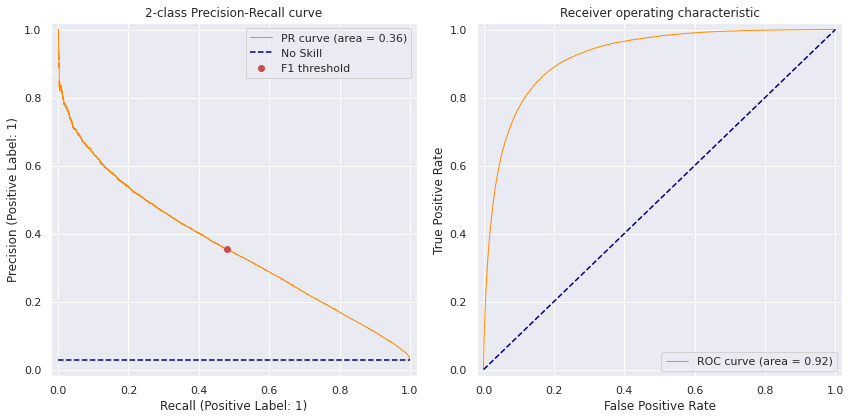

In [21]:
sns.set()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
no_skill = y_test.sum()/len(y_test)
ax[0].plot(recall, precision, color='darkorange', lw=1, label='PR curve (area = %0.2f)' % auprc)
ax[0].plot([0, 1], [no_skill, no_skill], color='navy', linestyle='--', label='No Skill')

ax[0].plot(recall[threshold_idx],
           precision[threshold_idx], 'ro', label='F1 threshold')

ax[0].set_xlabel('Recall (Positive Label: 1)')
ax[0].set_ylabel('Precision (Positive Label: 1)')
ax[0].set_title('2-class Precision-Recall curve')
ax[0].set_xlim([-0.02, 1.02])
ax[0].set_ylim([-0.02, 1.02])
ax[0].legend()

fpr, tpr, thresholds = roc_curve(cupy2numpy(true_labels, True), cupy2numpy(preds, True))
# roc_auc = roc_auc_score(true_labels, pred_labels)
roc_auc = roc_auc_score(true_labels, preds)
ax[1].plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
ax[1].plot([-0, 1], [0, 1], color='navy', linestyle='--')
ax[1].set_xlim([-0.02, 1.02])
ax[1].set_ylim([-0.02, 1.02])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver operating characteristic')
ax[1].legend(loc="lower right")
plt.tight_layout()
plt.savefig(f'{figures_path}/xgb_pr_roc_curves.png', dpi=600)


Confusion Matrix :


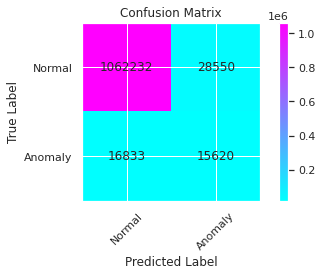

In [22]:
results = confusion_matrix(true_labels, pred_labels)
results = cupy2numpy(results, True)

print ('Confusion Matrix :')

plot_confusion_matrix(results, ['Normal','Anomaly'], title='Confusion Matrix', save_path=f'{figures_path}/xgb_confusion_matrix.png')

In [23]:
len(true_labels), len(y_test)

(1123235, 1123235)

In [24]:
type(pred_labels)

cupy._core.core.ndarray

In [25]:
# flag
print("Classification Report for XGBoost Classifier: \n", 
      classification_report(cupy2numpy(y_test, not use_cpu), cupy2numpy(pred_labels, not use_cpu)))
print("Confusion Matrix of XGBoost Classifier: \n", 
      confusion_matrix(cupy2numpy(y_test, not use_cpu), cupy2numpy(pred_labels, not use_cpu)))

Classification Report for XGBoost Classifier: 
               precision    recall  f1-score   support

           0       0.98      0.97      0.98   1090782
           1       0.35      0.48      0.41     32453

    accuracy                           0.96   1123235
   macro avg       0.67      0.73      0.69   1123235
weighted avg       0.97      0.96      0.96   1123235

Confusion Matrix of XGBoost Classifier: 
 [[1062232   28550]
 [  16833   15620]]


## Explainability with Shap

In [26]:
shap_time = time.time()

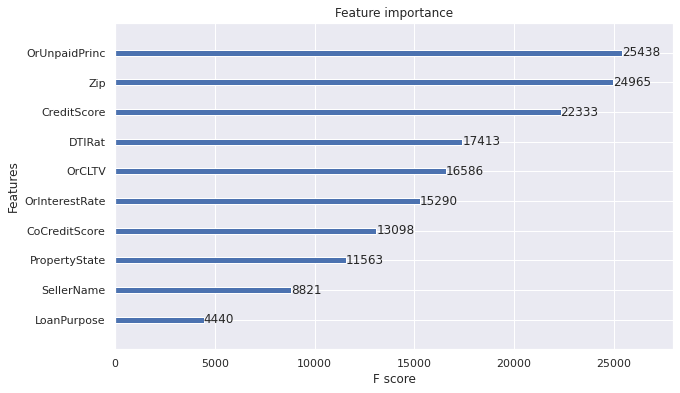

In [27]:
x = plt.rcParams["figure.figsize"] = [10,6]
fig, ax = plt.subplots()
xgb.plot_importance(model, max_num_features=10, ax = ax)
plt.savefig(f'{figures_path}/xgb_feat_importance.png', dpi=600)

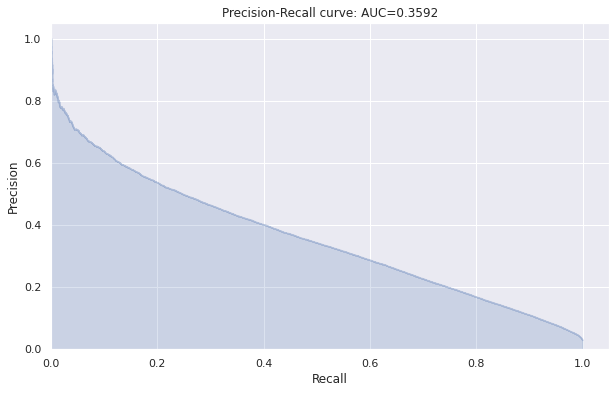

In [28]:
# Function for plotting Precision Recall curve and measuring AUC
def plot_precision_recall(y_test: np.array, y_score: np.array, isPR = True) -> None:
    #print(y_test[0:20],y_score[0:20])
    precision, recall, _ = precision_recall_curve(y_test, y_score) if isPR else roc_curve(y_test, y_score)
    auc_score = auc(recall, precision)
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title('Precision-Recall curve: AUC={0:0.4f}'.format(auc_score))
    plt.show()

plt.rcParams["figure.figsize"] = [10,6]
plot_precision_recall(cupy2numpy(y_test.values, not use_cpu), cupy2numpy(preds, True))

Here is the key step of computing GPU-accelerated Shapley values for all rows.

In [29]:
## shap Tree Explainer
start = time.time()
    
expl = shap.TreeExplainer(model)
shap_values = expl.shap_values(X_test)
tshap = time.time()-start
print(f'Elapsed: {time.time()-start: 0.4f} sec')
print(shap_values.shape)
print(f'XGBoost version: {xgb.__version__}')

start = time.time()
sns.set()

Elapsed:  79.1308 sec
(1123235, 20)
XGBoost version: 1.4.2


In [30]:
np.save(f'{clean_data_path}/xgb_shap.npy', shap_values)

In [31]:
# save for dashboarding
X_train.to_parquet(f'{clean_data_path}/xgb_xtrain.parquet')
y_train.to_frame().to_parquet(f'{clean_data_path}/xgb_ytrain.parquet')

X_test.to_parquet(f'{clean_data_path}/xgb_xtest.parquet')
y_test.to_frame().to_parquet(f'{clean_data_path}/xgb_ytest.parquet')


In [32]:
if False:
  if use_cpu: 
    shap.summary_plot(shap_values, X_test)
  else: 
    shap.summary_plot(shap_values, X_test.to_pandas(), sort=False, show=False)
    
  plt.tight_layout()

if False:
    ax = f.gca()
    ax.set_xlim([-5, 5])

    f = plt.gcf()
    f.savefig(f'{figures_path}/Shap_XGBoost_1200.png', dpi=6000)
    print(f'Elapsed: {time.time()-start: 0.4f} sec')

Note the magnitude of the OrInterestRate and CreditScore on Default = 1 rows below.

## PyTorch

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim

EPOCHS = 20
BATCH_SIZE = 2048
LEARNING_RATE = 0.0001

device = torch.device("cuda:0" if torch.cuda.is_available() and not use_cpu else "cpu")
print(device)

cuda:0


In [25]:
pyt_time = time.time()

In [26]:
Xcolumns=['Channel',
         'SellerName',
         'OrInterestRate',
         'OrUnpaidPrinc',
         'OrLoanTerm',
         'OrCLTV',
         'NumBorrow',
         'DTIRat',
         'CreditScore',
         'FTHomeBuyer',
         'LoanPurpose',
         'PropertyType',
         'NumUnits',
         'OccStatus',
         'PropertyState',
         'Zip',
         'ProductType',
         'CoCreditScore',
         'Extra',
         'MortInsType']
CONTINUOUS_COLUMNS = ['OrInterestRate', 'OrUnpaidPrinc', 'OrLoanTerm', 'OrCLTV', 'NumBorrow', 'DTIRat', 
                      'CreditScore', 'NumUnits', 'CoCreditScore', 'Extra']
CATEGORICAL_COLUMNS = sorted([i for i in Xcolumns if i not in CONTINUOUS_COLUMNS])
LABEL_COLUMNS = ['Default']

### Scale numerical data

In [27]:
std_scaler = StandardScaler()

In [28]:
X_train[CONTINUOUS_COLUMNS].head()

,OrInterestRate,OrUnpaidPrinc,OrLoanTerm,OrCLTV,NumBorrow,DTIRat,CreditScore,NumUnits,CoCreditScore,Extra
1550205,1.117746,-0.996131,-1.531372,-2.909084,-1.164326,-0.904846,0.985658,-0.133009,0.004986,-0.000487
1137124,1.616116,-0.084862,0.637020,-0.650462,-1.164326,2.717158,-2.276635,-0.133009,0.004986,-0.000487
541402,1.616116,-1.060646,0.637020,-2.561604,0.816595,0.155253,0.630152,-0.133009,1.013539,-0.000487
5374781,0.394622,-1.270318,-1.531372,0.276153,-1.164326,0.420278,-1.712007,-0.133009,0.004986,-0.000487
2269471,1.371817,1.205431,0.637020,0.565720,-1.164326,1.303693,0.253734,-0.133009,0.004986,-0.000487


In [29]:
# fit and transform data on train set
scaled_col_data = std_scaler.fit_transform(X_train[CONTINUOUS_COLUMNS])

if not use_cpu:
    scaled_col_data = scaled_col_data.values

for col_num, col in enumerate(CONTINUOUS_COLUMNS):
    X_train[col] = scaled_col_data[:, col_num]

del scaled_col_data
X_train[CONTINUOUS_COLUMNS].head()

,OrInterestRate,OrUnpaidPrinc,OrLoanTerm,OrCLTV,NumBorrow,DTIRat,CreditScore,NumUnits,CoCreditScore,Extra
1550205,1.117746,-0.996131,-1.531372,-2.909084,-1.164326,-0.904846,0.985658,-0.133009,0.004986,-0.000487
1137124,1.616116,-0.084862,0.637020,-0.650462,-1.164326,2.717158,-2.276635,-0.133009,0.004986,-0.000487
541402,1.616116,-1.060646,0.637020,-2.561604,0.816595,0.155253,0.630152,-0.133009,1.013539,-0.000487
5374781,0.394622,-1.270318,-1.531372,0.276153,-1.164326,0.420278,-1.712007,-0.133009,0.004986,-0.000487
2269471,1.371817,1.205431,0.637020,0.565720,-1.164326,1.303693,0.253734,-0.133009,0.004986,-0.000487


In [30]:
X_train[CONTINUOUS_COLUMNS].isna().sum(), X_test[CONTINUOUS_COLUMNS].isna().sum()

(OrInterestRate    0
 OrUnpaidPrinc     0
 OrLoanTerm        0
 OrCLTV            0
 NumBorrow         0
 DTIRat            0
 CreditScore       0
 NumUnits          0
 CoCreditScore     0
 Extra             0
 dtype: uint64,
 OrInterestRate    0
 OrUnpaidPrinc     0
 OrLoanTerm        0
 OrCLTV            0
 NumBorrow         0
 DTIRat            0
 CreditScore       0
 NumUnits          0
 CoCreditScore     0
 Extra             0
 dtype: uint64)

In [31]:
# transform data on test set
test_scaled_col_data = std_scaler.transform(X_test[CONTINUOUS_COLUMNS])
if not use_cpu:
    test_scaled_col_data = test_scaled_col_data.values
    
for col_num, col in enumerate(CONTINUOUS_COLUMNS):
    X_test[col] = test_scaled_col_data[:, col_num]
del test_scaled_col_data

In [32]:
y_train

1550205     0
1137124     1
541402      0
5374781     0
2269471     0
           ..
9214207     0
10613369    0
4343224     0
8759119     0
2998321     0
Name: Default, Length: 10109124, dtype: int64

### OPTIONAL: Apply random over sampler of minority class

In [33]:
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.combine import SMOTEENN

# #oversampler = SMOTEENN()
# oversampler = RandomOverSampler(sampling_strategy=.90) #was: .90 Apply to only X_train, y_train
# if not use_cpu:
#     X_train, y_train = oversampler.fit_resample(X_train, y_train)
# else:
#     X_train, y_train = oversampler.fit_resample(X_train.as_matrix(), cp.asnumpy(y_train))
#     X_train = DataFrame(X_train, columns=CATEGORICAL_COLUMNS + CONTINUOUS_COLUMNS)
#     y_train = Series(y_train, name=LABEL_COLUMNS[0])

# print(X_train.shape, y_train.shape)

### Model Definition

In [34]:
cards = []
for key in sorted(mappings):
    print(key, len(set(mappings[key])))
    cards.append(len(set(mappings[key])))

Channel 3
FTHomeBuyer 3
LoanPurpose 4
MortInsType 2
OccStatus 3
ProductType 1
PropertyState 54
PropertyType 5
SellerName 49
Zip 961


In [35]:
# view classifier model - it is imported above
!cat /rapids/notebooks/clfmodel.py

############################################################################
##
## Copyright (C) 2021 NVIDIA Corporation.  All rights reserved.
##
## NVIDIA Sample Code
##
## Please refer to the NVIDIA end user license agreement (EULA) associated
## with this source code for terms and conditions that govern your use of
## this software. Any use, reproduction, disclosure, or distribution of
## this software and related documentation outside the terms of the EULA
## is strictly prohibited.
##
############################################################################

import torch
import torch.nn as nn

class binaryClassification(nn.Module):
    def __init__(self, cat_cards, numer_dims=10):
        """
        cat_cards (list): list of integers, where each integer is the cardinality of the SORTED column names
        numer_dims (int): number of numerical dimensions
        """
        super(binaryClassification, self).__init__()
        self.num_cats = len(cat_cards)
        
#         

In [36]:
def save_checkpoint(model, optimizer, epoch: int, best_score, file_name, threshold, save_path: str, k_fold=0):
    """
    Save checkpoint to pytorch .pt file.
    Args:
        model: Instance of Pytorch model.
        optimizer: pytorch optimizer ex. torch.optim.Adam() instance
        epoch: epoch number
        best_score: model best score acccoring to appropriate metric.
                    Can be multiple, just save as a dict. of {'metric': score}
        k_fold: int or string for K-folds.
        file_name (str): filename usually including the name of the model.:

    Returns:

    """
    checkpoint = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'k_fold': k_fold,
        'epoch': epoch,
        'best_score': best_score,
        'threshold': threshold
    }
    if not save_path:
        save_path = '.'
    os.makedirs(f'{save_path}/checkpoints/', exist_ok=True)

    torch.save(checkpoint, f'{save_path}/checkpoints/{file_name}.pt')


def load_checkpoint(file_name: str, model, device: str, save_path: str):
    """
    Load Checkpoint from pytorch .pt file.

    Args:
        device: str
        file_name (str): filename usually including the name of the model.
        model_cls: (uninstantiated) class belonging to a custom nn.Module
        **kwargs:

    Returns:

    """
    # instantiate the model and pass in input params as kwargs.
    model = model.to(device)
    if not save_path:
        save_path = '.'
    checkpoint = torch.load(f'{save_path}/checkpoints/{file_name}.pt')
    model.load_state_dict(checkpoint['model'])
    model.eval()
    return model, checkpoint['threshold']

In [37]:
def train_epoch(model, loader, optimizer, loss_func, metric, device, epoch=''):
    model.train()
    model.zero_grad()
    train_loss = torch.zeros(len(loader), requires_grad=False, device=device)
    train_acc = torch.zeros(len(loader), requires_grad=False, device=device)
    batch = 0
    pbar = tqdm(loader)
    
    train_logits = []
    train_targets = []
    

    for x_cat, x_cont, target in pbar:
        # make prediction
        logits = model(x_cat, x_cont).squeeze()
        
        # calculate loss
        loss = loss_func(logits, target)  # criterion
        loss.backward()
        optimizer.step()
        for param in model.parameters():
            param.grad = None
        
        train_loss[batch] = loss.detach()
        train_acc[batch] = metric(logits, target)
        
        train_targets.append(target.detach())
        train_logits.append(logits.detach())
        
        batch += 1
        if batch == len(loader) or not batch %100:
            pbar.set_description(f'Epoch: {epoch} mean loss {train_loss[:batch].mean().cpu(): 0.5f}, ' 
                                 f'mean acc: {train_acc[:batch].mean().cpu(): 0.5f}')
        
    return train_loss, train_logits, train_targets  


def val_epoch(model, loader, loss_func, device):
    model.eval()
    val_logits = []
    val_targets = []
    val_loss = torch.zeros(len(loader), requires_grad=False, device=device)
    
    with torch.no_grad():
        batch=0
        for x_cat, x_cont, target in tqdm(iter(loader)):
            # make prediction
            logits = model(x_cat, x_cont).squeeze()
            
            # calculate loss
            loss = loss_func(logits, target)  # criterion
            
            # save some data
            val_targets.append(target.detach())
            val_logits.append(logits.detach())
            val_loss[batch] = loss.detach()
            batch+=1
        val_loss = val_loss.mean()
    return val_loss, val_logits, val_targets


def calc_metrics(model, _targets, _logits, tst_loader, loss_func, device, use_cpu):
    # scoring on train
    if not use_cpu:
        _targets = cp.asarray(torch.cat(_targets)).astype(int)
        _probs = cp.asarray(torch.sigmoid(torch.cat(_logits)))
    else:
        _targets = np.array(torch.cat(_targets)).astype(int)
        _probs = np.array(torch.sigmoid(torch.cat(_logits)))

    # # calc precision, recall and find threshold for maximum F1 score on train.
    precision, recall, thresholds = precision_recall_curve(_targets, _probs)
    
    threshold_idx = argmax((2 * precision * recall) / (precision + recall))
    threshold = thresholds[threshold_idx]

    # now on test set
    _, _logits, _targets = val_epoch(model, tst_loader, loss_func, device)
    if not use_cpu:
        _targets = cp.asarray(torch.cat(_targets)).astype(int)
        _probs = cp.asarray(torch.sigmoid(torch.cat(_logits)))
    else:
        _targets = np.array(torch.cat(_targets)).astype(int)
        _probs = np.array(torch.sigmoid(torch.cat(_logits)))
    
    precision, recall, thresholds = precision_recall_curve(_targets, _probs)
    # find threshold index closest to threshold value on train set.
    
    if not use_cpu:
        threshold_idx = cp.argmin(cp.abs(thresholds - threshold))
    else:
        threshold_idx = np.argmin(np.abs(thresholds - threshold))
    
    pred_labels = (_probs >= threshold).astype(int)

    auc_sc = roc_auc_score(_targets, _probs)
    acc_sc = accuracy_score(_targets, pred_labels)
    f1_sc = (2 * precision[threshold_idx] * recall[threshold_idx]) / (precision[threshold_idx] + recall[threshold_idx])
    conf_mat = confusion_matrix(_targets, pred_labels)
    print(f'F1: {f1_sc.item(): 0.4f} '
          f'AUC: {auc_sc: 0.4f} '
          f'Pr: {precision[threshold_idx].item(): 0.4f} '
          f'Rec: {recall[threshold_idx].item(): 0.4f} ', 
          f'Acc: {acc_sc: 0.4f} '
          f'Thresh: {threshold.item(): 0.4f} '
          f'Pred Def: {pred_labels.sum().item()} '
          f'Actual: {int(_targets.sum())} '
          )
    print('Confusion Matrix: \n:', conf_mat)
    return f1_sc.item(), threshold.item()
    
    
def test_em(model, loader, loss_func, threshold, device, use_cpu, save_path: str = None):
    sns.set()
    test_loss, test_logits, test_targets = val_epoch(model, loader, loss_func, device)
    
    # scoring
    if not use_cpu:
        test_targets = cp.asarray(torch.cat(test_targets)).astype(int)
        test_probs = cp.asarray(torch.sigmoid(torch.cat(test_logits)))
    else:
        test_targets = torch.cat(test_targets).numpy().astype(int)
        test_probs = torch.sigmoid(torch.cat(test_logits)).numpy()
    pred_labels = (test_probs >= threshold).astype(int)

    precision, recall, thresholds = precision_recall_curve(test_targets, test_probs)
    
    if not use_cpu:
        threshold_idx = cp.argmin(cp.abs(thresholds - threshold))
    else:
        threshold_idx = np.argmin(np.abs(thresholds - threshold))
    
    auc_sc = roc_auc_score(test_targets, test_probs)
    acc_sc = accuracy_score(test_targets, pred_labels)
    f1_sc = (2 * precision[threshold_idx] * recall[threshold_idx]) / (precision[threshold_idx] + recall[threshold_idx])
    conf_mat = confusion_matrix(test_targets, pred_labels)
    
    auprc= auc(cupy2numpy(recall, not use_cpu), cupy2numpy(precision, not use_cpu))

    print(f'Thresh: {threshold: 0.4f}', f'Prec: {precision[threshold_idx].item(): 0.4f}',
          f'Rec: {recall[threshold_idx].item(): 0.4f}', f'Pred Def: {pred_labels.sum()}',
          f'Actual: {int(test_targets.sum())}', f'AUC: {auc_sc: 0.4f}',
          f'Acc: {acc_sc: 0.4f}',
          f'F1: {f1_sc.item(): 0.4f}',
          f'AUPRC: {auprc: 0.4f}',
         )
    print('Confusion Matrix: \n:', conf_mat)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    no_skill = cupy2numpy(test_targets.mean(), not use_cpu) 
    ax[0].plot(cupy2numpy(recall, not use_cpu), cupy2numpy(precision, not use_cpu), color='darkorange', lw=1, label='PR curve (area = %0.2f)' % auprc)
    ax[0].plot([0,1], [no_skill, no_skill], color='navy', linestyle='--', label='No Skill')
    ax[0].plot(cupy2numpy(recall[threshold_idx], not use_cpu), cupy2numpy(precision[threshold_idx], not use_cpu), 'ro', label='F1 threshold')
    ax[0].set_xlabel('Recall')
    ax[0].set_ylabel('Precision')
    ax[0].set_xlim([-0.02, 1.02])
    ax[0].set_ylim([-0.02, 1.02])
    ax[0].set_title('Precision-Recall curve')
    ax[0].legend()
    
    fpr, tpr, threshold = roc_curve(cupy2numpy(test_targets, not use_cpu), cupy2numpy(test_probs, not use_cpu))
    roc_auc = auc(fpr, tpr)

    ax[1].set_title('Receiver Operating Characteristic')
    ax[1].plot(fpr, tpr, 'b', label = 'ROC curve (area = %0.2f)' % roc_auc)
    ax[1].legend(loc = 'lower right')
    ax[1].plot([0, 1], [0, 1],'r--')
    ax[1].set_xlim([-0.02, 1.02])
    ax[1].set_ylim([-0.02, 1.02])
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_xlabel('False Positive Rate')   
    
    plt.tight_layout()
    if save_path and isinstance(save_path, str):
        plt.savefig(save_path, dpi=600)
    print("Classification Report for Pytorch Classifier: \n",
          classification_report(cupy2numpy(test_targets, not use_cpu), cupy2numpy(pred_labels, not use_cpu)))
    return test_targets, pred_labels

### Pick ONE of NVTabular (recommended w/ GPU) OR Pytorch Dataloader

In [38]:
# for explainability later.
y_pos = y_test.loc[y_test==1].sample(n=BATCH_SIZE, random_state=8675309)
y_neg = y_test.loc[y_test==0].sample(n=BATCH_SIZE, random_state=8675309)
X_test_pos = X_test.loc[y_pos.index]
X_test_neg = X_test.loc[y_neg.index]


In [39]:
pyt_data_prep_time = time.time()

### Pytorch Dataloader and Dataset

In [36]:
from torch.utils.data import Dataset, DataLoader

In [37]:
X_train.shape

(10109124, 20)

In [38]:
X_train[CONTINUOUS_COLUMNS]

,OrInterestRate,OrUnpaidPrinc,OrLoanTerm,OrCLTV,NumBorrow,DTIRat,CreditScore,NumUnits,CoCreditScore,Extra
1550205,1.117743,-0.996140,-1.531366,-2.909132,-1.164328,-0.904860,0.985665,-0.132996,0.005000,-0.000504
1137124,1.616121,-0.084862,0.637021,-0.650480,-1.164328,2.717126,-2.276593,-0.132996,0.005000,-0.000504
541402,1.616121,-1.060655,0.637021,-2.561647,0.816602,0.155234,0.630162,-0.132996,1.013563,-0.000504
5374781,0.394607,-1.270329,-1.531366,0.276147,-1.164328,0.420257,-1.711971,-0.132996,0.005000,-0.000504
2269471,1.371818,1.205442,0.637021,0.565717,-1.164328,1.303668,0.253748,-0.132996,0.005000,-0.000504
...,...,...,...,...,...,...,...,...,...,...
9214207,-0.826907,1.584468,0.637021,-0.997965,0.816602,-1.964953,0.567426,-0.132996,0.605517,-0.000504
10613369,-1.193361,-0.673564,0.637021,0.623631,-1.164328,-0.639836,0.671986,-0.132996,0.005000,-0.000504
4343224,0.150304,-0.213893,-1.531366,-0.824222,0.816602,-0.904860,-0.018107,-0.132996,0.856622,-0.000504
8759119,-1.559815,0.519968,-1.531366,0.565717,-1.164328,-0.816519,1.194784,-0.132996,0.005000,-0.000504


In [53]:
CATEGORICAL_COLUMNS

['Channel',
 'FTHomeBuyer',
 'LoanPurpose',
 'MortInsType',
 'OccStatus',
 'ProductType',
 'PropertyState',
 'PropertyType',
 'SellerName',
 'Zip']

In [149]:
## train data
class PytData(Dataset):

    def __init__(self, X_data, y_data, cont_cols, cat_cols, device):
        if device.type != 'cpu':
            self.X_data_cont = torch.tensor(X_data[cont_cols].as_gpu_matrix(), dtype=torch.float32, device=device)
            self.X_data_cat = torch.tensor(X_data[cat_cols].as_gpu_matrix(), dtype=torch.int64, device=device)
        else:
            self.X_data_cont = torch.tensor(X_data[cont_cols].values, dtype=torch.float32, device=device)
            self.X_data_cat = torch.tensor(X_data[cat_cols].values, dtype=torch.int64, device=device)
        
        assert len(cont_cols) == self.X_data_cont.shape[1]
        assert len(cat_cols) == self.X_data_cat.shape[1]
        
        self.y_data = torch.tensor(y_data.values, dtype=torch.float32, device=device)
        
    def __getitem__(self, index):
        return self.X_data_cat[index], self.X_data_cont[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.y_data)


train_data = PytData(X_train, y_train, CONTINUOUS_COLUMNS, CATEGORICAL_COLUMNS, device)
test_data = PytData(X_test, y_test, CONTINUOUS_COLUMNS, CATEGORICAL_COLUMNS, device)

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE)

#for explainability later
pos_data = PytData(X_test_pos, y_pos, CONTINUOUS_COLUMNS, CATEGORICAL_COLUMNS, device)
neg_data = PytData(X_test_neg, y_neg, CONTINUOUS_COLUMNS, CATEGORICAL_COLUMNS, device)

pos_loader = DataLoader(dataset=pos_data, batch_size=BATCH_SIZE)
neg_loader = DataLoader(dataset=neg_data, batch_size=BATCH_SIZE)

with open(f'{clean_data_path}/pos_loader.pkl', 'wb') as f:
    pickle.dump(pos_loader, f)
    
with open(f'{clean_data_path}/neg_loader.pkl', 'wb') as f:
    pickle.dump(neg_loader, f)

with open(f'{clean_data_path}/test_loader.pkl', 'wb') as f:
    pickle.dump(test_loader, f)


### Model Training - Pytorch Dataloader

In [150]:

model = binaryClassification(cat_cards=cards, numer_dims=len(CONTINUOUS_COLUMNS)).to(device)
print(model, device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=20, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=512, bias=True)
  (layer_4): Linear(in_features=512, out_features=512, bias=True)
  (layer_5): Linear(in_features=512, out_features=512, bias=True)
  (layer_out): Linear(in_features=512, out_features=1, bias=True)
  (prelu1): PReLU(num_parameters=1)
  (prelu2): PReLU(num_parameters=1)
  (prelu3): PReLU(num_parameters=1)
  (prelu4): PReLU(num_parameters=1)
  (prelu5): PReLU(num_parameters=1)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (dropout3): Dropout(p=0.1, inplace=False)
  (dropout4): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(512, 

In [59]:

def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    return acc


model_name = 'fnma_model_mlp_pyt'

start = time.time()
max_f1 = 0
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    train_loss, train_logits, train_targets = train_epoch(model, train_loader, optimizer, criterion, metric=binary_acc, device=device,
                             epoch=e)
    epoch_f1_score, threshold = calc_metrics(model, train_targets, train_logits, test_loader, criterion, device, use_cpu=use_cpu)
    if epoch_f1_score > max_f1:
        max_f1 = epoch_f1_score
        # save the model
        save_checkpoint(model, optimizer, e, epoch_f1_score, model_name, threshold=threshold, save_path=clean_data_path)
    
print(f'Total time: {time.time() - start}')

  0%|          | 0/4937 [00:00<?, ?it/s]

  0%|          | 0/549 [00:00<?, ?it/s]

F1:  0.3751 AUC:  0.9130 Pr:  0.3079 Rec:  0.4798  Acc:  0.9538 Thresh:  0.1903 Pred Def: 50577 Actual: 32453 
Confusion Matrix: 
: [[1055776   35006]
 [  16882   15571]]


  0%|          | 0/4937 [00:00<?, ?it/s]

  0%|          | 0/549 [00:00<?, ?it/s]

F1:  0.3859 AUC:  0.9157 Pr:  0.3256 Rec:  0.4737  Acc:  0.9564 Thresh:  0.1909 Pred Def: 47211 Actual: 32453 
Confusion Matrix: 
: [[1058944   31838]
 [  17080   15373]]
Total time: 260.4687271118164


In [60]:
model, threshold = load_checkpoint(model_name, model, device, save_path=clean_data_path)

  0%|          | 0/4937 [00:00<?, ?it/s]

Thresh:  0.1909 Prec:  0.3269 Rec:  0.5120 Pred Def: 626182 Actual: 399783 AUC:  0.9098 Acc:  0.9390 F1:  0.3990 AUPRC:  0.3402
Confusion Matrix: 
: [[9287852  421489]
 [ 195090  204693]]
Classification Report for Pytorch Classifier: 
               precision    recall  f1-score   support

           0       0.98      0.96      0.97   9709341
           1       0.33      0.51      0.40    399783

    accuracy                           0.94  10109124
   macro avg       0.65      0.73      0.68  10109124
weighted avg       0.95      0.94      0.95  10109124



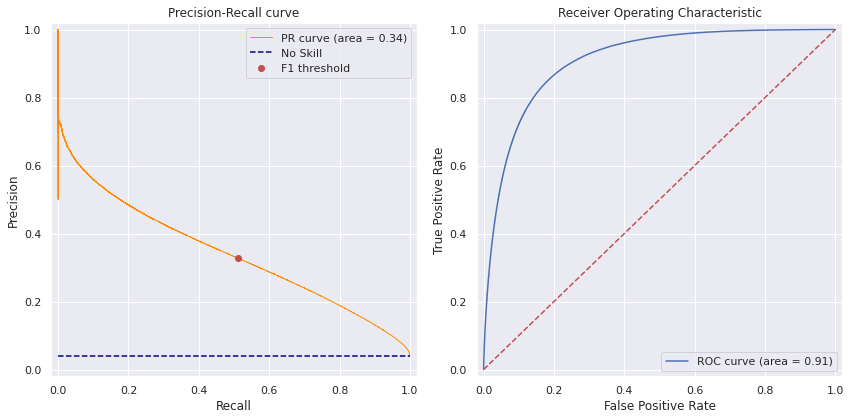

In [61]:
_ = test_em(model, train_loader, criterion, threshold, device, use_cpu=use_cpu,
        save_path=f'{figures_path}/in_sample_mlp_pyt_pr_roc.png' )

  0%|          | 0/549 [00:00<?, ?it/s]

Thresh:  0.1909 Prec:  0.3256 Rec:  0.4737 Pred Def: 47211 Actual: 32453 AUC:  0.9157 Acc:  0.9564 F1:  0.3859 AUPRC:  0.3190
Confusion Matrix: 
: [[1058944   31838]
 [  17080   15373]]
Classification Report for Pytorch Classifier: 
               precision    recall  f1-score   support

           0       0.98      0.97      0.98   1090782
           1       0.33      0.47      0.39     32453

    accuracy                           0.96   1123235
   macro avg       0.65      0.72      0.68   1123235
weighted avg       0.97      0.96      0.96   1123235



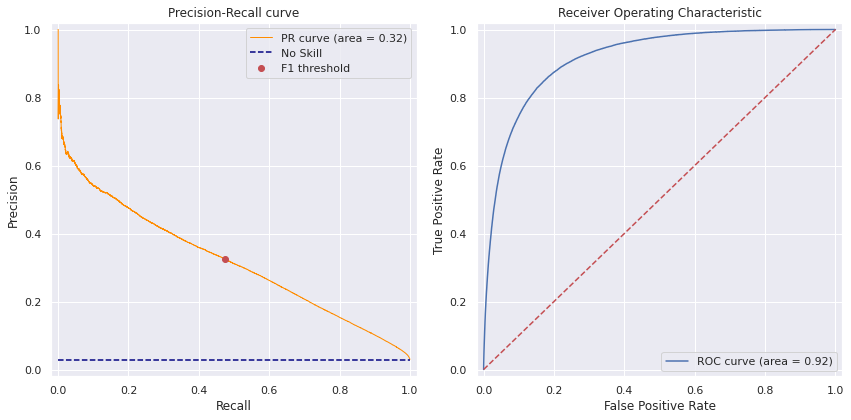

In [62]:
true_labels, pred_labels = test_em(model, test_loader, criterion, threshold, device, use_cpu=use_cpu, 
                                   save_path=f'{figures_path}/out_of_sample_mlp_pyt_pr_roc.png')

In [63]:
type(results)

numpy.ndarray

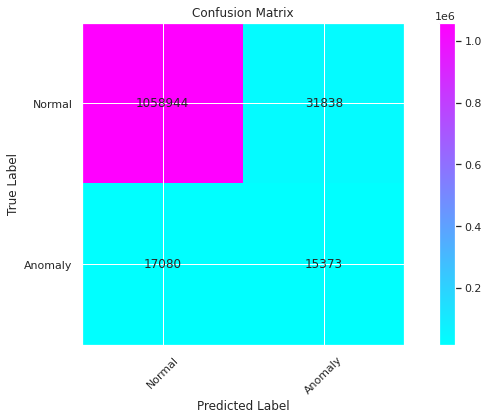

In [64]:
results = confusion_matrix(true_labels, pred_labels)
results = cupy2numpy(results, True)
plot_confusion_matrix(results, ['Normal','Anomaly'], title='Confusion Matrix', save_path=f'{figures_path}/pyt_mlp_confusion_matrix.png')

In [40]:
import cudf
import pyarrow.parquet as pq
#!pip install librosa --user
#!pip install llvmlite --ignore-installed
#!pip install nvtabular==0.5.3
pyt_dl_time = time.time()

### (GPU only) NVTabular Dataloader and Dataset

In [40]:
import nvtabular as nvt
from nvtabular.loader.torch import TorchAsyncItr, DLDataLoader

if use_cpu:
    raise Exception('This section is for GPU only.')
        

In [42]:
nvt.__version__

'0.5.3'

In [43]:
train = concat([X_train[sorted(X_train.columns)],  y_train], axis=1)
train[CATEGORICAL_COLUMNS] = train[CATEGORICAL_COLUMNS].astype(int16)
train.head()

,Channel,CoCreditScore,CreditScore,DTIRat,Extra,FTHomeBuyer,LoanPurpose,MortInsType,NumBorrow,NumUnits,OccStatus,OrCLTV,OrInterestRate,OrLoanTerm,OrUnpaidPrinc,ProductType,PropertyState,PropertyType,SellerName,Zip,Default
1550205,2,0.004986,0.985658,-0.904846,-0.000487,0,2,0,-1.164326,-0.133009,1,-2.909084,1.117746,-1.531372,-0.996131,0,4,4,31,902,0
1137124,1,0.004986,-2.276635,2.717158,-0.000487,0,0,0,-1.164326,-0.133009,1,-0.650462,1.616116,0.637020,-0.084862,0,21,3,48,120,1
541402,2,1.013539,0.630152,0.155253,-0.000487,0,0,0,0.816595,-0.133009,1,-2.561604,1.616116,0.637020,-1.060646,0,23,4,31,437,0
5374781,2,0.004986,-1.712007,0.420278,-0.000487,0,2,0,-1.164326,-0.133009,0,0.276153,0.394622,-1.531372,-1.270318,0,28,3,3,195,0
2269471,1,0.004986,0.253734,1.303693,-0.000487,0,2,0,-1.164326,-0.133009,1,0.565720,1.371817,0.637020,1.205431,0,51,4,3,475,0


In [44]:
test = concat([X_test[sorted(X_test.columns)],  y_test], axis=1)
test[CATEGORICAL_COLUMNS] = test[CATEGORICAL_COLUMNS].astype(cp.int16)
test.head()

,Channel,CoCreditScore,CreditScore,DTIRat,Extra,FTHomeBuyer,LoanPurpose,MortInsType,NumBorrow,NumUnits,OccStatus,OrCLTV,OrInterestRate,OrLoanTerm,OrUnpaidPrinc,ProductType,PropertyState,PropertyType,SellerName,Zip,Default
9793327,1,-0.461690,-0.352718,-0.728163,-0.000487,0,2,0,0.816595,-0.133009,1,1.086941,-0.949021,0.637020,-0.939681,0,9,4,18,273,0
4115999,0,-1.277774,-1.063731,0.155253,-0.000487,0,2,0,0.816595,-0.133009,1,-0.476721,-0.460423,-1.531372,-0.592915,0,45,3,18,734,0
8502057,2,-2.313573,-1.586534,0.950327,-0.000487,0,0,0,0.816595,-0.133009,1,-0.882115,-1.510908,-1.531372,-1.036453,0,51,4,31,470,0
6870604,1,1.201866,0.922922,-0.816504,-0.000487,0,2,0,0.816595,-0.133009,1,0.160326,-0.460423,-0.808575,-0.181634,0,16,3,26,396,0
6856426,1,1.013539,0.860186,0.066911,-0.000487,0,1,0,0.816595,-0.133009,1,0.623633,-0.338274,0.637020,-0.826780,0,34,3,26,847,0


In [45]:
# for explainability later.
y_pos = y_test.loc[y_test==1].sample(n=BATCH_SIZE, random_state=8675309)
y_neg = y_test.loc[y_test==0].sample(n=BATCH_SIZE, random_state=8675309)

X_test_pos = X_test.loc[y_pos.index]
X_test_neg = X_test.loc[y_neg.index]

pos_data = concat([X_test_pos[sorted(X_test_pos.columns)],  y_pos], axis=1)
pos_data[CATEGORICAL_COLUMNS] = pos_data[CATEGORICAL_COLUMNS].astype(int16)

neg_data = concat([X_test_neg[sorted(X_test_neg.columns)],  y_neg], axis=1)
neg_data[CATEGORICAL_COLUMNS] = neg_data[CATEGORICAL_COLUMNS].astype(int16)

pos_path = f'{clean_data_path}/fnma_pos_test.parquet'
neg_path = f'{clean_data_path}/fnma_neg_test.parquet'

pos_data.to_parquet(pos_path)
neg_data.to_parquet(neg_path)

In [46]:
# save train and test (not necessary but saves time from re-processing data if you restart kernel)

# train_path = 'fnma_train_nvt_ros.parquet'
# test_path = 'fnma_test_nvt_ros.parquet'

train_path = f'{clean_data_path}/fnma_train_nvt.parquet'
test_path = f'{clean_data_path}/fnma_test_nvt.parquet'

In [47]:
train.to_parquet(train_path)
test.to_parquet(test_path)

In [48]:
train_dataset = TorchAsyncItr(
    nvt.Dataset(train_path),
    cats=CATEGORICAL_COLUMNS,
    conts=CONTINUOUS_COLUMNS,
    labels=LABEL_COLUMNS,
    batch_size=BATCH_SIZE,
    shuffle=True
)

train_loader = DLDataLoader(
   train_dataset,
   batch_size=None,
   pin_memory=False,
   num_workers=0
)

test_dataset = TorchAsyncItr(
   nvt.Dataset(test_path),
   cats=CATEGORICAL_COLUMNS,
   conts=CONTINUOUS_COLUMNS,
   labels=LABEL_COLUMNS,
   batch_size=BATCH_SIZE
)

test_loader = DLDataLoader(
   test_dataset,
   batch_size=None,
   pin_memory=False,
   num_workers=0
)


### Model Training - NVTabular Dataloader

In [49]:

model = binaryClassification(cat_cards=cards, numer_dims=len(CONTINUOUS_COLUMNS)).to(device)

print(model)
criterion = nn.BCEWithLogitsLoss() # pos_weight=torch.tensor(25, device=device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=20, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=512, bias=True)
  (layer_4): Linear(in_features=512, out_features=512, bias=True)
  (layer_5): Linear(in_features=512, out_features=512, bias=True)
  (layer_out): Linear(in_features=512, out_features=1, bias=True)
  (prelu1): PReLU(num_parameters=1)
  (prelu2): PReLU(num_parameters=1)
  (prelu3): PReLU(num_parameters=1)
  (prelu4): PReLU(num_parameters=1)
  (prelu5): PReLU(num_parameters=1)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (dropout3): Dropout(p=0.1, inplace=False)
  (dropout4): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(512, 

In [62]:
def binary_acc(y_pred, y_test):
    with torch.no_grad():
        y_pred_tag = torch.round(torch.sigmoid(y_pred))
        correct_results_sum = (y_pred_tag == y_test).sum().float()
        acc = correct_results_sum/y_test.shape[0]
    return acc

model_name = 'fnma_model_mlp_nvt'

start = time.time()
max_f1 = 0
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    train_loss, train_logits, train_targets = train_epoch(model, train_loader, optimizer, criterion, metric=binary_acc, device=device,
                             epoch=e)
    epoch_f1_score, threshold = calc_metrics(model, train_targets, train_logits, test_loader, criterion, device, use_cpu)
    if epoch_f1_score > max_f1:
        max_f1 = epoch_f1_score
        # save the model
        save_checkpoint(model, optimizer, e, epoch_f1_score, model_name, threshold=threshold, save_path=clean_data_path)
    
print(f'Total time: {time.time() - start}')


  0%|          | 0/4937 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.3836 AUC:  0.9155 Pr:  0.3367 Rec:  0.4457  Acc:  0.9586 Thresh:  0.1956 Pred Def: 42941 Actual: 32439 
Confusion Matrix: 
: [[1062314   28482]
 [  17980   14459]]


  0%|          | 0/4937 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.3835 AUC:  0.9157 Pr:  0.3419 Rec:  0.4367  Acc:  0.9595 Thresh:  0.1930 Pred Def: 41435 Actual: 32439 
Confusion Matrix: 
: [[1063528   27268]
 [  18272   14167]]


  0%|          | 0/4937 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.3899 AUC:  0.9175 Pr:  0.3443 Rec:  0.4492  Acc:  0.9594 Thresh:  0.1937 Pred Def: 42322 Actual: 32439 
Confusion Matrix: 
: [[1063047   27749]
 [  17866   14573]]


  0%|          | 0/4937 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.3932 AUC:  0.9187 Pr:  0.3259 Rec:  0.4955  Acc:  0.9558 Thresh:  0.1998 Pred Def: 49325 Actual: 32439 
Confusion Matrix: 
: [[1057546   33250]
 [  16364   16075]]


  0%|          | 0/4937 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.0001 AUC:  0.9199 Pr:  1.0000 Rec:  0.0000  Acc:  0.9711 Thresh:  0.9517 Pred Def: 0 Actual: 32439 
Confusion Matrix: 
: [[1090796       0]
 [  32439       0]]


  0%|          | 0/4937 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.3946 AUC:  0.9199 Pr:  0.3265 Rec:  0.4987  Acc:  0.9558 Thresh:  0.1999 Pred Def: 49550 Actual: 32439 
Confusion Matrix: 
: [[1057424   33372]
 [  16261   16178]]


  0%|          | 0/4937 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.3969 AUC:  0.9202 Pr:  0.3433 Rec:  0.4702  Acc:  0.9587 Thresh:  0.1992 Pred Def: 44427 Actual: 32439 
Confusion Matrix: 
: [[1061622   29174]
 [  17186   15253]]


  0%|          | 0/4937 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.3980 AUC:  0.9207 Pr:  0.3324 Rec:  0.4959  Acc:  0.9567 Thresh:  0.1959 Pred Def: 48384 Actual: 32439 
Confusion Matrix: 
: [[1058497   32299]
 [  16354   16085]]


  0%|          | 0/4937 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.3981 AUC:  0.9206 Pr:  0.3494 Rec:  0.4626  Acc:  0.9596 Thresh:  0.2029 Pred Def: 42948 Actual: 32439 
Confusion Matrix: 
: [[1062855   27941]
 [  17432   15007]]


  0%|          | 0/4937 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.0001 AUC:  0.9209 Pr:  1.0000 Rec:  0.0000  Acc:  0.9711 Thresh:  0.9437 Pred Def: 0 Actual: 32439 
Confusion Matrix: 
: [[1090796       0]
 [  32439       0]]


  0%|          | 0/4937 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.3999 AUC:  0.9212 Pr:  0.3472 Rec:  0.4715  Acc:  0.9591 Thresh:  0.2005 Pred Def: 44049 Actual: 32439 
Confusion Matrix: 
: [[1062042   28754]
 [  17144   15295]]


  0%|          | 0/4937 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.3971 AUC:  0.9212 Pr:  0.3315 Rec:  0.4953  Acc:  0.9566 Thresh:  0.1993 Pred Def: 48473 Actual: 32439 
Confusion Matrix: 
: [[1058390   32406]
 [  16372   16067]]


  0%|          | 0/4937 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.0001 AUC:  0.9215 Pr:  1.0000 Rec:  0.0000  Acc:  0.9711 Thresh:  0.9547 Pred Def: 0 Actual: 32439 
Confusion Matrix: 
: [[1090796       0]
 [  32439       0]]


  0%|          | 0/4937 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.3991 AUC:  0.9216 Pr:  0.3737 Rec:  0.4281  Acc:  0.9628 Thresh:  0.2061 Pred Def: 37166 Actual: 32439 
Confusion Matrix: 
: [[1067518   23278]
 [  18551   13888]]


  0%|          | 0/4937 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.3976 AUC:  0.9207 Pr:  0.3349 Rec:  0.4893  Acc:  0.9572 Thresh:  0.2086 Pred Def: 47396 Actual: 32439 
Confusion Matrix: 
: [[1059271   31525]
 [  16568   15871]]


  0%|          | 0/4937 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.3987 AUC:  0.9217 Pr:  0.3337 Rec:  0.4952  Acc:  0.9569 Thresh:  0.2029 Pred Def: 48136 Actual: 32439 
Confusion Matrix: 
: [[1058723   32073]
 [  16376   16063]]


  0%|          | 0/4937 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.4010 AUC:  0.9221 Pr:  0.3529 Rec:  0.4642  Acc:  0.9599 Thresh:  0.2048 Pred Def: 42666 Actual: 32439 
Confusion Matrix: 
: [[1063188   27608]
 [  17381   15058]]


  0%|          | 0/4937 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.4002 AUC:  0.9217 Pr:  0.3634 Rec:  0.4454  Acc:  0.9614 Thresh:  0.2049 Pred Def: 39762 Actual: 32439 
Confusion Matrix: 
: [[1065482   25314]
 [  17991   14448]]


  0%|          | 0/4937 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.4010 AUC:  0.9224 Pr:  0.3402 Rec:  0.4884  Acc:  0.9579 Thresh:  0.2031 Pred Def: 46576 Actual: 32439 
Confusion Matrix: 
: [[1060064   30732]
 [  16595   15844]]


  0%|          | 0/4937 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.3996 AUC:  0.9222 Pr:  0.3594 Rec:  0.4500  Acc:  0.9609 Thresh:  0.2071 Pred Def: 40623 Actual: 32439 
Confusion Matrix: 
: [[1064772   26024]
 [  17840   14599]]
Total time: 382.2052869796753


In [52]:
model, threshold = load_checkpoint(model_name, model, device, save_path=clean_data_path)

0it [00:00, ?it/s]

Thresh:  0.1900 Prec:  0.3335 Rec:  0.4758 Pred Def: 570338 Actual: 399797 AUC:  0.9070 Acc:  0.9417 F1:  0.3922 AUPRC:  0.3326
Confusion Matrix: 
: [[9329222  380105]
 [ 209564  190233]]
Classification Report for Pytorch Classifier: 
               precision    recall  f1-score   support

           0       0.98      0.96      0.97   9709327
           1       0.33      0.48      0.39    399797

    accuracy                           0.94  10109124
   macro avg       0.66      0.72      0.68  10109124
weighted avg       0.95      0.94      0.95  10109124



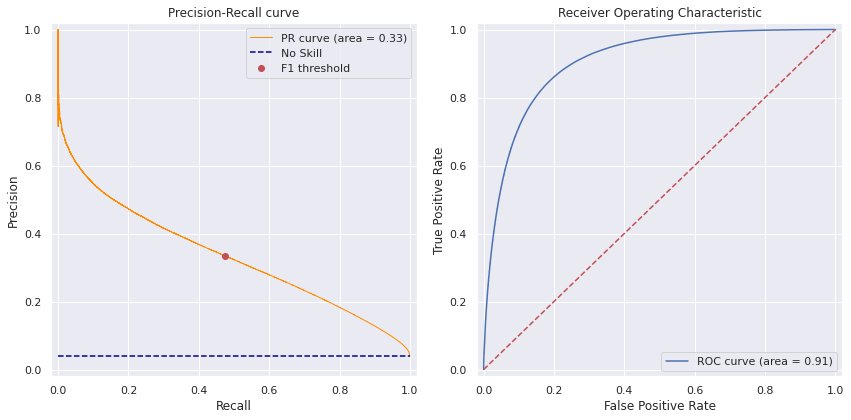

In [53]:
# in sample performance.
_ = test_em(model, train_loader, criterion, threshold, device, use_cpu=use_cpu,
            save_path=f'{figures_path}/in_sample_nvt_mlp_pyt_pr_roc.png')

0it [00:00, ?it/s]

Thresh:  0.1900 Prec:  0.3310 Rec:  0.4388 Pred Def: 42994 Actual: 32439 AUC:  0.9135 Acc:  0.9582 F1:  0.3774 AUPRC:  0.3104
Confusion Matrix: 
: [[1062035   28761]
 [  18206   14233]]
Classification Report for Pytorch Classifier: 
               precision    recall  f1-score   support

           0       0.98      0.97      0.98   1090796
           1       0.33      0.44      0.38     32439

    accuracy                           0.96   1123235
   macro avg       0.66      0.71      0.68   1123235
weighted avg       0.96      0.96      0.96   1123235



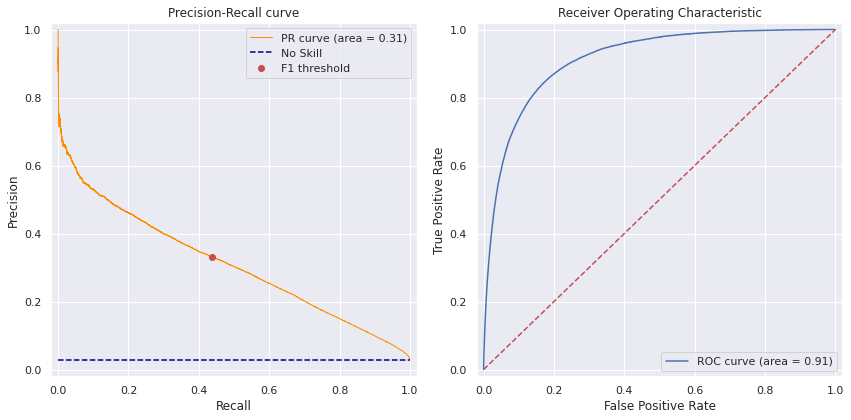

In [54]:
# out of sample performance.
true_labels, pred_labels = test_em(model, test_loader, criterion, threshold, device, use_cpu=use_cpu,
                                   save_path=f'{figures_path}/out_of_sample_nvt_mlp_pyt_pr_roc.png')

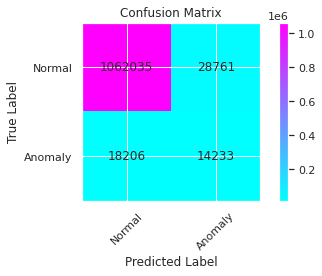

In [55]:
results = confusion_matrix(true_labels, pred_labels)
results = cupy2numpy(results, True)
plot_confusion_matrix(results, ['Normal','Anomaly'], title='Confusion Matrix', save_path=f'{figures_path}/nvt_mlp_confusion_matrix.png')

# Timings

In [56]:
nvt_time = time.time()

In [57]:
figures_path = '/rapids/notebooks/figures'

In [58]:
import seaborn as sns
sns.set()

Text(0.5, 0, 'latency in seconds')

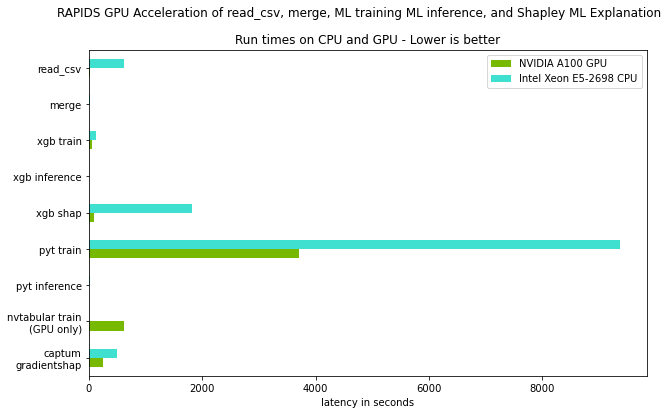

In [5]:
#Orig from Aug 2 2021:
fig, ax = plt.subplots(figsize=(10,6))
#These timings are current as of Sep 2, 2020
data = [[614.2, 19.5, 125.9, .176, 1821.1, 9370.6, 27.7, 0.0, 504.0],
         [16.4, .137, 54.6, .007, 102.1, 3712.4, 4.3, 631.0, 254.9]]

steps = ['read_csv', 'merge', 'xgb train', 'xgb inference',
         'xgb shap', 'pyt train', 'pyt inference', 'nvtabular train\n(GPU only)',
         'captum\ngradientshap']
steps.reverse()
data[0].reverse()
data[1].reverse()
#data[2].reverse()
cpu = data[0]
a100 = data[1]
#a100 = data[2]
DF = pd.DataFrame({#'NVIDIA A100 GPU': a100,
                   'NVIDIA A100 GPU': a100,
                   'Intel Xeon E5-2698 CPU': cpu}, index=steps)
dict = {#"NVIDIA A100 GPU": "darkgreen",
    "NVIDIA A100 GPU": "#76B900","CPU": "turquoise"}
_ = DF.plot.barh(color=dict.values(), ax=ax)
plt.suptitle("RAPIDS GPU Acceleration of read_csv, merge, ML training ML inference, and Shapley ML Explanation")
ax.set_title('Run times on CPU and GPU - Lower is better')
ax.set_xlabel('latency in seconds')

# print("               RAPIDS GPU Acceleration of read_csv, merge, ML training,")
# print("                       ML inference, and Shapley ML Explanation")

PermissionError: [Errno 13] Permission denied: '/rapids/notebooks/figures/perf_plot_preprocess.png'

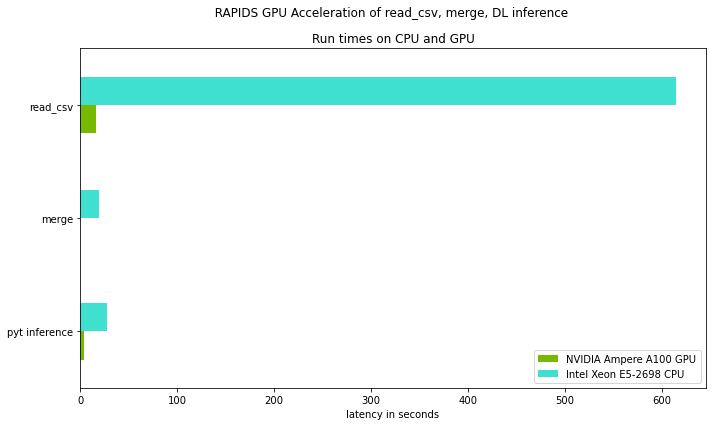

In [14]:
fig, ax = plt.subplots(figsize=(10,6))
#These timings are current as of Aug 2, 2021
data = [[614.2, 19.5, 27.7],
         [16.4, .137, 4.3]]

steps = ['read_csv','merge', 'pyt inference']

steps.reverse()
data[0].reverse()
data[1].reverse()
cpu = data[0]
a100 = data[1]
DF = pd.DataFrame({'NVIDIA Ampere A100 GPU': a100,
                   'Intel Xeon E5-2698 CPU': cpu}, index=steps)
dct = {"NVIDIA Ampere A100 GPU": "#76B900","CPU": "turquoise"}
_ = DF.plot.barh(color=dct.values(), ax=ax)
ax.set_title('Run times on CPU and GPU')
ax.set_xlabel('latency in seconds')
plt.suptitle("                  RAPIDS GPU Acceleration of read_csv, merge, DL inference")
ax.legend(loc='lower right')
plt.tight_layout()
# print("                  RAPIDS GPU Acceleration of read_csv, merge, DL inference")
plt.savefig(f'{figures_path}/perf_plot_preprocess.png', dpi=600)

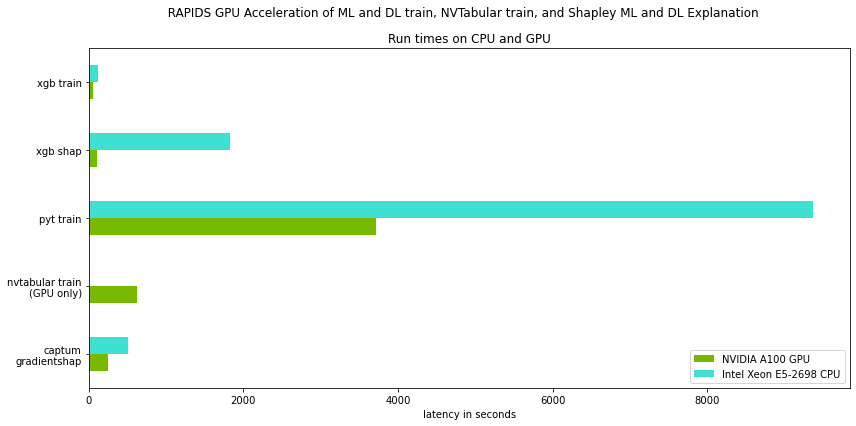

In [15]:
fig, ax = plt.subplots(figsize=(12,6))
#These timings are current as of Aug 2, 2021
data = [[125.9, 1821.1, 9370.6, 0.0, 504.0],
         [54.6, 102.1, 3712.4, 631.0, 254.9]]

steps = ['xgb train', 'xgb shap', 'pyt train', 'nvtabular train\n(GPU only)',
         'captum\ngradientshap']
steps.reverse()
data[0].reverse()
data[1].reverse()
cpu = data[0]
a100 = data[1]
DF = pd.DataFrame({'NVIDIA A100 GPU': a100,
                   'Intel Xeon E5-2698 CPU': cpu}, index=steps)
dct = {"NVIDIA Ampere A100 GPU": "#76B900","CPU": "turquoise"}
_ = DF.plot.barh(color=dict.values(), ax=ax)
ax.set_title('Run times on CPU and GPU')
ax.set_xlabel('latency in seconds')
plt.suptitle("                  RAPIDS GPU Acceleration of ML and DL train, NVTabular train, and Shapley ML and DL Explanation")
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig(f'{figures_path}/perf_plot_train.png', dpi=800)
# print("    RAPIDS GPU Acceleration of ML and DL train, NVTabular train, and Shapley ML and DL Explanation")

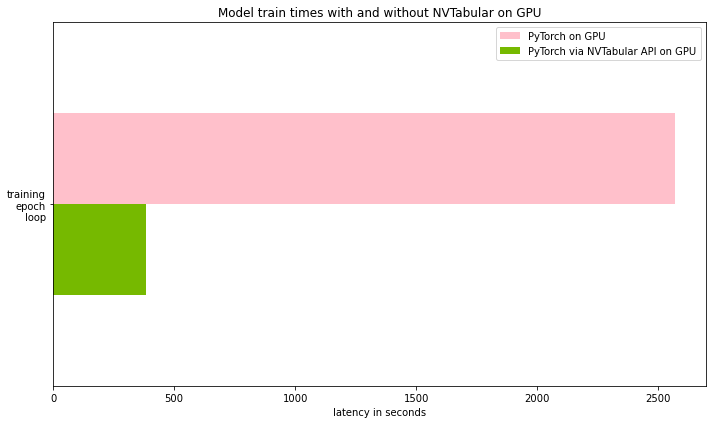

In [17]:
fig, ax = plt.subplots(figsize=(10,6))
#These timings are current as of Aug 2, 2021
data = [[382.2], [2567.3]]

# steps = ['xgb train', 'xgb shap', 'pyt train', 'nvtabular train\n(GPU only)',
#          'captum\ngradientshap']
# steps.reverse()
# data[0].reverse()
# data[1].reverse()
nvt_a100 = data[0]
pyt_a100 = data[1]
DF = pd.DataFrame({'PyTorch via NVTabular API on GPU': nvt_a100, 'PyTorch on GPU': pyt_a100},
                  index=['training\nepoch\nloop'],
                 )
color_dict = {"PyTorch via NVTabular API on GPU":  "#76B900", "PyTorch on GPU": "pink"}
_ = DF.plot.barh(color=color_dict.values(), ax=ax)
ax.set_title('Model train times with and without NVTabular on GPU')
ax.set_xlabel('latency in seconds')
# ax.set_ylabel('training\nepoch\nloop', rotation=0)
# plt.suptitle("                  Train times with and without NVTabular on GPU")
ax.legend(loc='upper right')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
plt.tight_layout()
plt.savefig(f'{figures_path}/perf_plot_nvt_train.png', dpi=600)

# fig.subplots_adjust()

In [ ]:
DF

In [ ]:
pyt_a100

In [ ]:
fig, ax = plt.subplots()
ax.barh(y=[0,1], width=[nvt_a100[0], pyt_a100[0]], color=['pink', 'lightgreen'])
_=ax.set_yticklabels([])

In [ ]:
# total run time
print(nvt_time - total_start )

In [ ]:
cum_time = [i - total_start for i in [data_prep_time, shap_time, pyt_time, pyt_data_prep_time, pyt_dl_time, nvt_time]]
print(cum_time)

In [ ]:
#  Tested on n a A100 32 GB GPU CUDA 11.2 Driver 460.32.03 on July 16, 2021
# gpu_cum_time = [5.847876310348511, 77.14555883407593, 345.10619354248047, 347.9490294456482, 2602.528173685074, 2990.594742298126]